In [70]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import catboost
import json
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
import torchmetrics
import seaborn

from torch import nn
from tqdm.auto import tqdm
import math


from torch.nn.utils.rnn import pad_sequence 
from torch.utils.data import DataLoader
from razdel import tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

from collections import defaultdict

%matplotlib inline

In [72]:
def parce_mfcc_line(line):
    mfcc = [i for i in map(float, filter(lambda x: x, line.split('|')))]
    # assert len(mfcc)==12, f'{line=} {mfcc=}'
    return mfcc

In [3]:
# data_xml = ET.parse('data/jokes1.xml')
# root = data_xml.getroot()

In [4]:
# for i, sentence in enumerate(list(root)):
#     item_seq = []
#     for word in list(sentence.findall('word')):
#         print(word.tag, word.attrib, word.text)
#         for c in list(word):
#             print(c.tag, c.attrib, c.text)
#     break

In [5]:
def get_base(path='data/jokes1.xml', count=float('inf')):   
    data_xml = ET.parse(path)
    root = data_xml.getroot()
    sentences = []
    for i, sent in enumerate(list(root)):
        item_seq = []
        for word in list(sent.findall('word')):
            #print(word.tag, word.attrib, word.text)
            if 'original' not in word.attrib:
                #print(word.tag, word.attrib, word.text)
                continue
            trans = [c.attrib['ph'] for c in list(word.findall('phoneme'))]
            allo_trans = [c.attrib['ph'] for c in list(word.findall('allophone'))]
            mfcc = [parce_mfcc_line(c.attrib['mfcc']) for c in list(word.findall('allophone'))]
            assert len(trans) == len(allo_trans), 'f{trans=} {allo_trans=}'
            item = {'original': word.attrib['original'],
                    'ph_trans': trans,
                   'allo_trans': allo_trans, 
                   'mfcc': mfcc}
            item_seq.append(item)
        sentences.append(item_seq)
        if i >=count:
            break
    return sentences
data = get_base()
data[0][0].keys

<function dict.keys>

In [6]:
import re
def char_phone_allo_conts(sents):
    
    chars = defaultdict(int)
    phones = defaultdict(int)
    allophones = defaultdict(int)
    
    for sent in sents:
        for s in sent:
            for c in s['original']:
                chars[c]+=1
            for p in s['ph_trans']:
                phones[p]+=1
            for a in s['allo_trans']:
                allophones[a]+=1
    return chars, phones, allophones

chars_counts, phone_counts, allo_counts = char_phone_allo_conts(data)


In [7]:
print(allo_counts)

defaultdict(<class 'int'>, {'d': 31316, 'r': 49742, 'u1': 20491, "z'": 4426, 'j': 61850, 'a0': 75381, 'm': 37974, 'a1': 88574, 'i0': 29945, 'sh': 21892, 't': 74116, 'o0': 62713, 'b': 19062, 'y4': 24524, 's': 49638, 'a2': 32238, "v'": 12822, 'e0': 46389, 'c': 12370, 'v': 46589, 'a4': 79619, "t'": 29989, 'g': 17411, 'z': 21369, "d'": 19547, 'l': 30099, 'n': 58937, "s'": 21801, "l'": 32384, 'i4': 75280, 'i1': 71859, 'u0': 20831, 'ch': 19026, 'o1': 1936, 'y0': 14694, "n'": 37981, 'h': 12031, 'zh': 16562, 'k': 50992, "p'": 8008, 'p': 39233, "m'": 12686, 'u4': 19830, "r'": 22092, 'sc': 6353, 'y1': 10968, "b'": 7313, 'f': 15452, "g'": 2310, "k'": 7893, 'H': 738, "h'": 553, "f'": 1583, 'C': 67, 'o4': 121, 'e1': 12, 'CH': 62, 'SC': 11})


In [8]:
#vocab_chars = {c:i for i,c in enumerate(['<PAD>', '<SOW>', '<EOW>', '<UNK>'] + list('абвгдеёжзийклмнопрстуфхцчшщъыьэюя,.!?-:'))}
#vocab_phones = {c:i for i, c in enumerate(['<PAD>', '<SOW>', '<EOW>'] + list(phone_counts.keys()))}


In [33]:
class Tokenizer:
    def __init__(self):
        self.id2allo = ['<PAD>', '<SOW>', '<EOW>'] + list(allo_counts.keys())
        self.vocab_allos = {c:i for i, c in enumerate(self.id2allo)}
        
    def get_num_allos(self):
        return len(self.vocab_allos)
        
    def get_allo_pad(self):
        return self.vocab_allos['<PAD>']
              
    def get_allo_eos(self):
        return self.vocab_allos['<EOW>']
    
    def get_allo_sos(self):
        return self.vocab_allos['<SOW>']
    
    def tokenize_item(self, item, eos=False, sos=False):
        allos = [self.vocab_allos[p] for p in item['allo_trans']]
        if eos:
            allos = allos + [self.get_allo_eos()]
        if sos:
            allos = [self.get_allo_sos()] + allos 
        return {'original': item['original'],
                'allos': torch.LongTensor(allos),
                'mfcc': torch.Tensor(item['mfcc'])}
    
    def convert_to_str(self, ids):
        return [self.id2allo[p_id] for p_id in ids]
       

In [34]:
tokenizer = Tokenizer()#vocab_chars, vocab_phones, vocab_allos)

In [35]:
train_sents, test_sents = train_test_split(data, random_state=42, train_size=0.9)
print(f'{len(train_sents)=} {len(test_sents)=}')

len(train_sents)=28722 len(test_sents)=3192


In [36]:
tokenizer.tokenize_item(train_sents[0][1])

{'original': 'собираетесь',
 'allos': tensor([17, 18, 49, 33,  4,  8,  7, 32, 24, 32, 30]),
 'mfcc': tensor([[-1.6563, -2.2166,  0.8081, -0.1208, -0.6138,  0.6541,  0.0511,  0.0069,
           0.2130, -0.0668,  0.2532,  0.2240],
         [-1.6036,  0.9226, -0.3021,  0.3414,  0.5319,  0.0045, -0.3544, -0.2907,
          -0.5060,  0.2235, -0.2849, -0.2422],
         [-2.4982,  1.0026,  0.9844,  0.4713,  0.2465,  0.1875,  0.2490,  0.1110,
           0.1316, -0.2013, -0.0277, -0.1297],
         [-1.5548,  0.7157, -0.3934,  0.5409,  0.9099,  0.0644, -0.3211, -0.4354,
          -0.4499,  0.3068, -0.4063, -0.3727],
         [-1.1864,  1.0103, -0.0262, -0.4557,  0.3519,  0.6018,  0.0193, -0.1357,
          -0.0668, -0.1528, -0.3075, -0.0094],
         [-0.7638,  0.6373, -0.4776,  0.3449,  0.2549, -0.1636, -0.4679, -0.4928,
          -0.5079,  0.3783, -0.2444, -0.2005],
         [-1.1476,  0.4669, -0.1523,  0.6649,  0.6351, -0.0343, -0.2571, -0.3677,
          -0.2433,  0.3627, -0.4419, -0.2943

In [37]:
class SeqAMDataSet:
    def __init__(self, sents, tokenizer):
        self.tokenizer = tokenizer
        self.tokenized = [[tokenizer.tokenize_item(item) for item in s] for s in sents]
        self.indexes = [(s_id, w_id) for s_id, s in enumerate(self.tokenized) for w_id in range(len(s))]
    
    def __len__(self):
        return len(self.indexes)
    
    def size(self, index):
        s_id, w_id = self.indexes[index]
        return len(self.tokenized[s_id][w_id])
    
    def __getitem__(self, index):
        s_id, w_id = self.indexes[index]
        return self.tokenized[s_id][w_id]
    
    def collate(self, items):
        #chars = [item['chars'] for item in items]
        #phones = [item['phones'] for item in items]
        allos = [item['allos'] for item in items]
        orig = [item['original'] for item in items]
        mfcc = [item['mfcc'] for item in items]
        #print(items)
        return {'allos': pad_sequence(allos, batch_first=False, padding_value=self.tokenizer.get_allo_pad()),
                'mfcc': pad_sequence(mfcc, batch_first=False, padding_value=0.0),
                'original': orig}
                

In [39]:

class SortedSampler(torch.utils.data.Sampler):
    def __init__(self, ds):
        self.ds = ds
        self.sizes_and_index = [(self.ds.size(i), i) for i in range(len(self.ds))]

    def __len__(self):
        return len(self.sizes_and_index)

    def __iter__(self):
        return iter((i for s, i in sorted(self.sizes_and_index)))
    
def make_sorted_dataloader(ds, min_sample_len=2, **kwargs):
    assert 'collate_fn' not in kwargs and 'sampler' not in kwargs and 'shuffle' not in kwargs , f"bad kwargs {kwargs}"
    return DataLoader(ds, 
                      collate_fn=ds.collate, 
                      sampler=SortedSampler(ds),
                      shuffle=False, 
                      **kwargs)

In [40]:
train_ds = SeqAMDataSet(train_sents, tokenizer)
test_ds = SeqAMDataSet(test_sents, tokenizer)

In [41]:
btz=256
train_dl = make_sorted_dataloader(train_ds, batch_size=btz)
test_dl = make_sorted_dataloader(test_ds, batch_size=btz)

In [42]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding", pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

class AMTransformerGen(nn.Module):
    def __init__(self, input_vs, mfcc_dim=12, dim=512, nhead=8, 
                                                num_encoder_layers=6, 
                                                dim_feedforward=1024, 
                                                dropout=0.1,
                                                input_padding_id=0):
        super().__init__()
        self.dim= dim
        self.input_padding_id=input_padding_id
        self.embeddings = nn.Embedding(input_vs, dim, padding_idx=input_padding_id)
        self.pos_embs = PositionalEncoding(dim, 0, 40)
        #self.out_embs = nn.Embedding(out_vs, dim, padding_idx=0)
        encoder_layer = torch.nn.TransformerEncoderLayer(d_model=dim, 
                                                         nhead=nhead, 
                                                         dim_feedforward=dim_feedforward, 
                                                         dropout=dropout,
                                                         batch_first=False)
        
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
    
        self.head = nn.Linear(dim, mfcc_dim)
    
    def forward(self, x):
        #print(f'{x.shape=} {tgt.shape=}')
        #print(f'{x=} {tgt=}')
        src_key_padding_mask = (x == self.input_padding_id).T
        x = self.embeddings(x) * math.sqrt(self.dim)
        x = self.pos_embs(x)
        #print(f'{x.shape=}')
        x = self.encoder(x)
        #tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.shape[0]).to(x.device)
        out = self.head(F.relu(x)) #* (x != self.input_padding_id).float()
        return out

In [47]:
class LitMSE(pl.LightningModule):
    def __init__(self, model, lr=1e-4):
        super().__init__()
        self.lr = lr
        self.model = model
        self.criterion = nn.MSELoss()
    
    def forward(self, x):
        return self.model(x)
    
    def compute_loss(self, batch, batch_idx):
        x, tgt = batch['allos'], batch['mfcc']
        #print(f'{x.shape=} {y.shape=}')
        logits = self(x)
        #print(f'{x.shape=}, {logits.shape=}, {tgt.shape=}')
        
        loss = self.criterion(logits.view(-1), tgt.view(-1))
        return loss, logits
    
    def training_step(self, batch, batch_idx):
        # Logging to TensorBoard by default
        loss, logits = self.compute_loss(batch, batch_idx)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, logits = self.compute_loss(batch, batch_idx)
        self.log("val_loss", loss,  prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        lr_scheduler = lr_scheduler_config = {           
            "scheduler": torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95),
            "interval": "epoch"}
        return {'optimizer': optimizer,
                'lr_scheduler': lr_scheduler}

In [48]:
tt = LitMSE(AMTransformerGen(tokenizer.get_num_allos()+1), lr=1e-4)
#tt = tt.load_from_checkpoint(model=TranscriptTransformer(tokenizer.get_num_chars()+1, tokenizer.get_num_phones()+1), checkpoint_path='models/tt2/lightning_logs/version_0/checkpoints/epoch=99-step=25799.ckpt')
trainer = pl.Trainer(gpus=1, 
                     auto_lr_find=True, 
                     max_epochs=10, 
                     log_every_n_steps=300, 
                     default_root_dir="models/3/AM.mse",)
                    #overfit_batches=10)
#trainer.tune(tt, train_dl, test_dl) # fit(dnn, train_dl)
print(f"best lr is {tt.lr}")
trainer.fit(tt, train_dl, test_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | AMTransformerGen | 12.7 M
1 | criterion | MSELoss          | 0     
-----------------------------------------------
12.7 M    Trainable params
0         Non-trainable params
12.7 M    Total params
50.618    Total estimated model params size (MB)


best lr is 0.0001


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 24. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validating: 0it [00:00, ?it/s]

/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 22. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

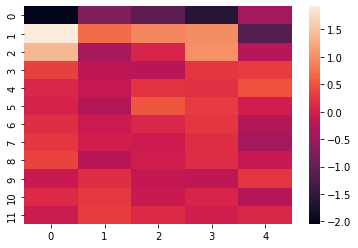

In [74]:
def plot_mfcc(mfcc, title='MFCC', **kwargs):
    seaborn.heatmap(mfcc.T.numpy(), **kwargs)
    plt.show()
plot_mfcc(test_ds[1]['mfcc'])

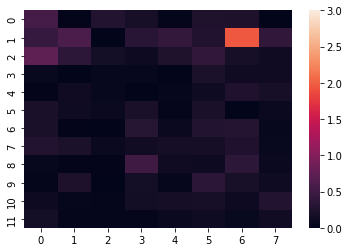

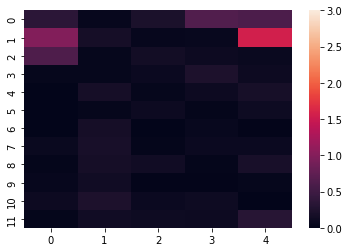

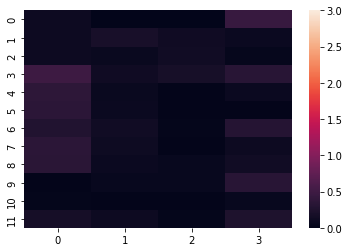

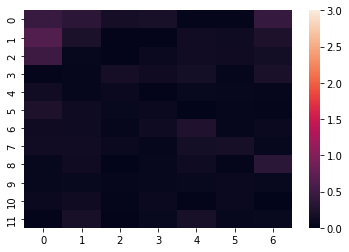

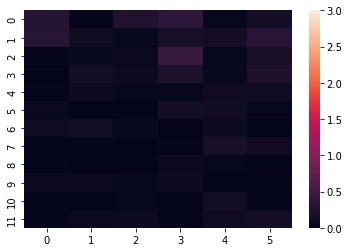

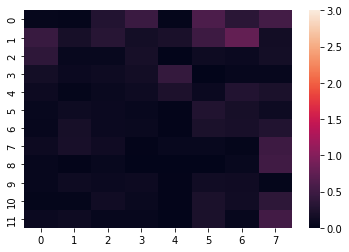

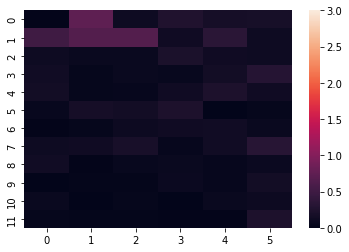

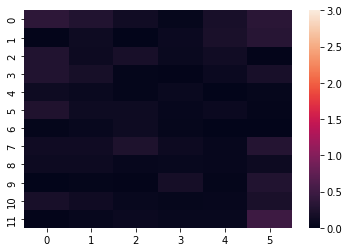

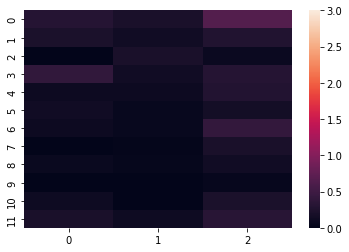

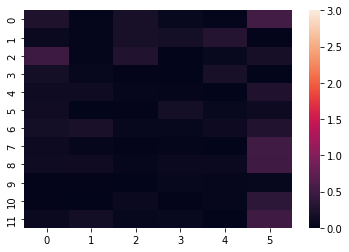

In [75]:
for i in range(10):
    item = test_ds[i]
    mfcc = item['mfcc']
    with torch.no_grad():
        logits = tt(item['allos'].view(-1, 1)).squeeze()
    diff = abs(mfcc - logits)
    plot_mfcc(diff, title=f'difference for {i} test item', vmin=0, vmax=3)


In [71]:
tt2 = tt.load_from_checkpoint(model=AMTransformerGen(tokenizer.get_num_allos()+1),
                             checkpoint_path='models/3/AM.mse/lightning_logs/version_6/checkpoints/epoch=9-step=10709.ckpt')

In [77]:
eval_base = get_base('data/lab2/test_submit.xml')

In [78]:
eval_base[0:2]

[[{'original': 'Реально', 'ph_trans': [], 'allo_trans': [], 'mfcc': []},
  {'original': 'начать', 'ph_trans': [], 'allo_trans': [], 'mfcc': []},
  {'original': 'день', 'ph_trans': [], 'allo_trans': [], 'mfcc': []},
  {'original': 'с', 'ph_trans': [], 'allo_trans': [], 'mfcc': []},
  {'original': 'улыбки -', 'ph_trans': [], 'allo_trans': [], 'mfcc': []},
  {'original': 'это', 'ph_trans': [], 'allo_trans': [], 'mfcc': []},
  {'original': 'проснуться', 'ph_trans': [], 'allo_trans': [], 'mfcc': []},
  {'original': 'от', 'ph_trans': [], 'allo_trans': [], 'mfcc': []},
  {'original': 'звонка', 'ph_trans': [], 'allo_trans': [], 'mfcc': []},
  {'original': 'будильника', 'ph_trans': [], 'allo_trans': [], 'mfcc': []},
  {'original': 'в', 'ph_trans': [], 'allo_trans': [], 'mfcc': []},
  {'original': 'одну', 'ph_trans': [], 'allo_trans': [], 'mfcc': []},
  {'original': 'минуту', 'ph_trans': [], 'allo_trans': [], 'mfcc': []},
  {'original': 'первого', 'ph_trans': [], 'allo_trans': [], 'mfcc': []},
 

In [79]:
eval_ds = SeqAMDataSet(eval_base, tokenizer)

In [83]:
eval_mfcc_predicted = []
with torch.no_grad():
    for i in tqdm(range(len(eval_ds))):
        item = eval_ds[i]
        logits = tt(item['allos'].view(-1, 1)).squeeze()
        item['mfcc'] = logits
        eval_mfcc_predicted.append(item)
    
print(eval_mfcc_predicted[:2])
#plot_mfcc(eval_mfcc_predicted[0]['mfcc'])

  0%|          | 0/3004 [00:00<?, ?it/s]

[{'original': 'Реально', 'allos': tensor([], dtype=torch.int64), 'mfcc': tensor([], size=(0, 12))}, {'original': 'начать', 'allos': tensor([], dtype=torch.int64), 'mfcc': tensor([], size=(0, 12))}]


In [115]:
#import simplejson as json

import pprint
def to_json(base, fname):
    root_json = []
    for sen in base:
        seq_json = []
        for item in sen:
            word = {'content': item['original'],
                   #'mfcc': '|'.join(( for c in item['mfcc'])} #TODO
            seq_json.append(word)
        root_json.append({'words': seq_json})
    #root_json = root_json[:2]
    with open(fname, 'w', encoding='utf-8') as outfile:
        out_str = json.dump(root_json, outfile, ensure_ascii=False, indent=4)
    #return {'root': root_json}
    return out_str

to_json(test_base_predicted, 'data/lab3/submit_mitrofanov.1.json')

In [116]:
!pip install simplejson

Looking in indexes: https://nid-artifactory.ad.speechpro.com/artifactory/api/pypi/pypi/simple, https://nid-artifactory.ad.speechpro.com/artifactory/api/pypi/asr3-pip-local/simple


In [ ]:
!head 'data/lab2/submit_mitrofanov2.5.json'